# Introduction and Overview
This Jupyter notebook show how machine learning was used to draw insights from the Education Attainment and Income score data generated previously. My hypothesis was that the data can be clearly categorized into clusters similar to the economic classes (i.e. lower class, middle class, upper class, etc.). However, after going through the analysis shown below, I found out instead that all the data forms a single cluster (this is clearly shown visually below), but I also propose an opinion on how clustering may be used and interpreted.

# Import and Prepare Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# read Census data CSV file into dataframe for Education Scores
census_df = pd.read_csv('Census Main Analysis Data.csv', 
                     dtype={"ZIPCODE":np.int32,"STATE":'category',
                             'ZipScore':np.float32,'YEAR':np.int32}).iloc[:,1:]

# read IRS AGI data CSV file into dataframe for Income Scores
IRS_df = pd.read_csv('IRS AGI Main Analysis Data.csv', 
                     dtype={"ZIPCODE":np.int32,"STATE":'category',
                             'ZipScore':np.float32,'YEAR':np.int32}).iloc[:,1:]

# Create combined DataFrame focusing on data from 2011
census_subset_df = census_df[['ZIPCODE','ZipScore',"STATE",'YEAR']][census_df.YEAR == 2011].drop_duplicates().rename(columns={'ZipScore':'EduScore'})
irs_subset_df = IRS_df[['ZIPCODE','ZipScore',"STATE",'YEAR']][IRS_df.YEAR == 2011].drop_duplicates().rename(columns={'ZipScore':'IncomeScore'})
df_2011 = census_subset_df.merge(irs_subset_df,on=['ZIPCODE','YEAR',"STATE"])

# Define data points as input for Silhoutte Score Analysis and K-Means Clustering 
points_2011 = [[e,i] for e,i in zip(df_2011.EduScore, df_2011.IncomeScore)]

# Create combined DataFrame focusing on data from 2017
census_subset_2017 = census_df[['ZIPCODE','ZipScore',"STATE",'YEAR']][census_df.YEAR == 2017].drop_duplicates().rename(columns={'ZipScore':'EduScore'})
irs_subset_2017 = IRS_df[['ZIPCODE','ZipScore',"STATE",'YEAR']][IRS_df.YEAR == 2017].drop_duplicates().rename(columns={'ZipScore':'IncomeScore'})
df_2017 = census_subset_df.merge(irs_subset_df,on=['ZIPCODE','YEAR',"STATE"])

# Define data points as input for Silhoutte Score Analysis and K-Means Clustering 
points_2017 = [[e,i] for e,i in zip(df_2017.EduScore, df_2017.IncomeScore)]

# Conduct Silhouette Score Analysis
Calculate Silhouette Scores and generate Silhouette Samples to determine best value of K for K-Means clustering 

For n_clusters = 2 The average silhouette_score is : 0.5252856652024483
For n_clusters = 3 The average silhouette_score is : 0.4285381461106456
For n_clusters = 4 The average silhouette_score is : 0.3908928494106969
For n_clusters = 5 The average silhouette_score is : 0.36040114861892203
For n_clusters = 6 The average silhouette_score is : 0.32400358123569484
For n_clusters = 7 The average silhouette_score is : 0.32995183018164187
For n_clusters = 8 The average silhouette_score is : 0.325949746057551
For n_clusters = 9 The average silhouette_score is : 0.3241716168487993
For n_clusters = 10 The average silhouette_score is : 0.32575591403683557


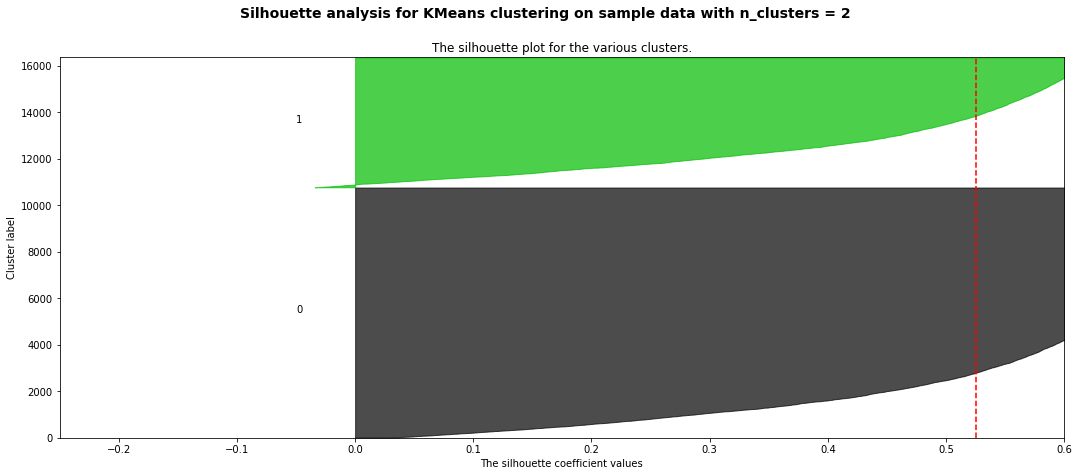

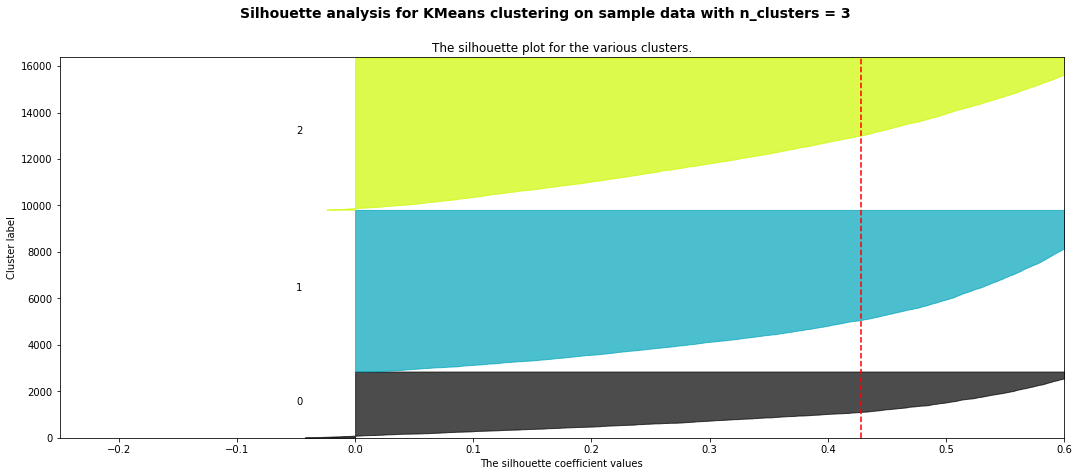

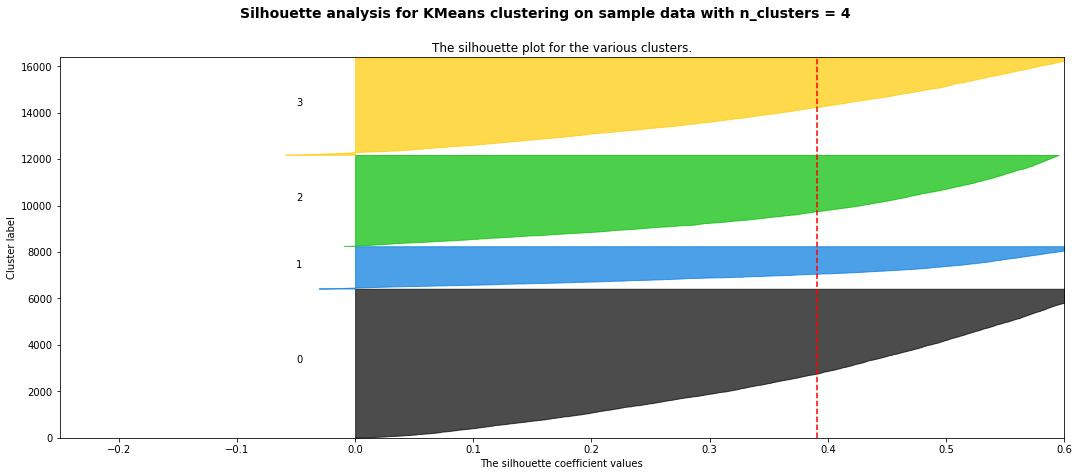

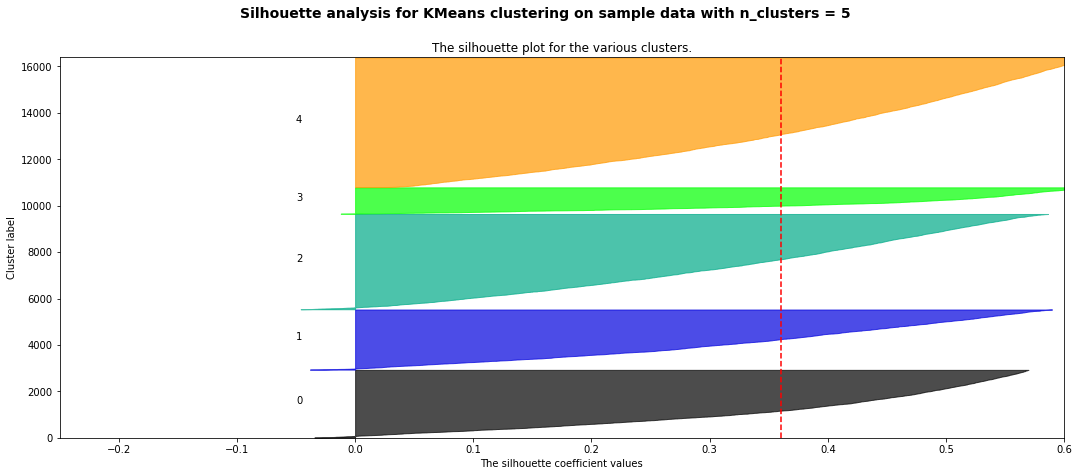

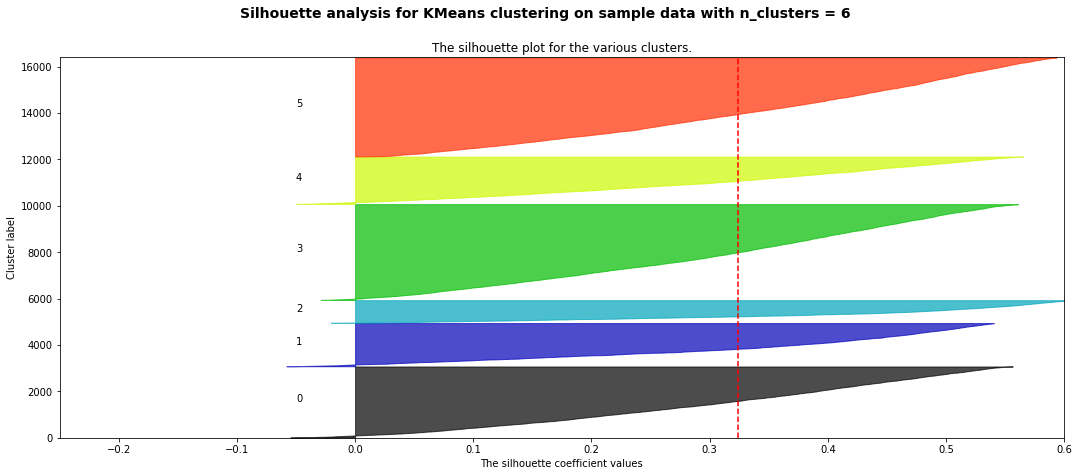

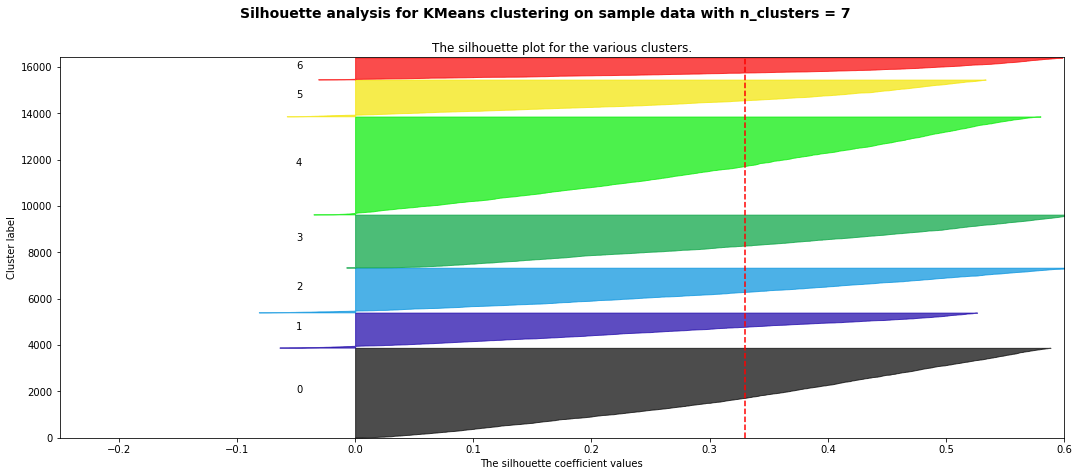

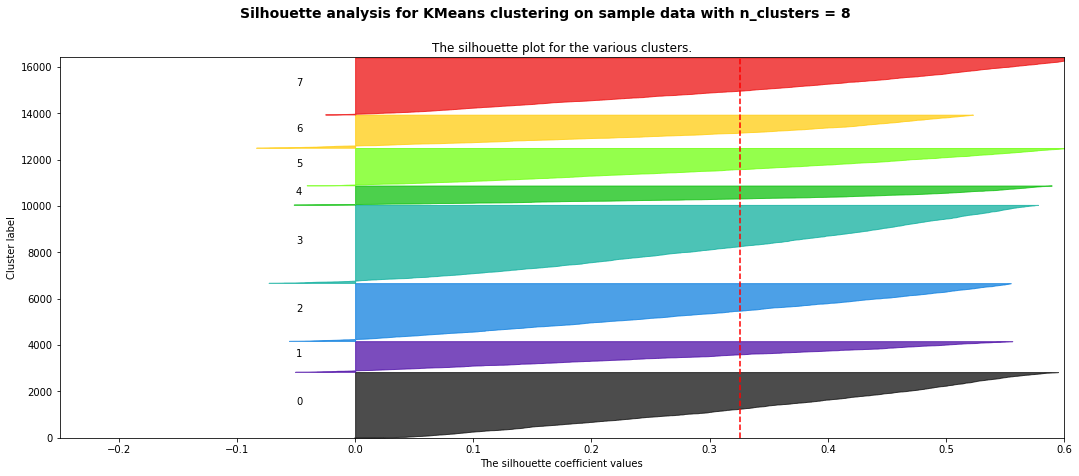

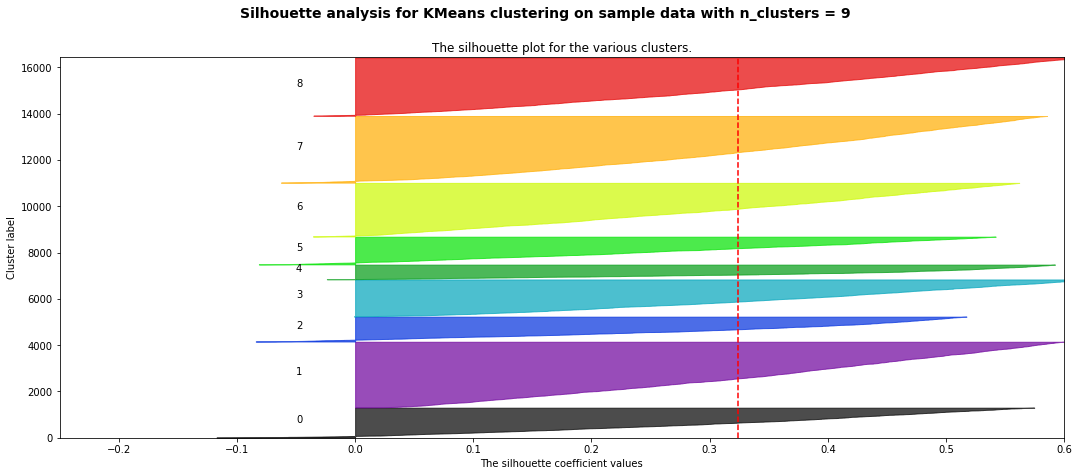

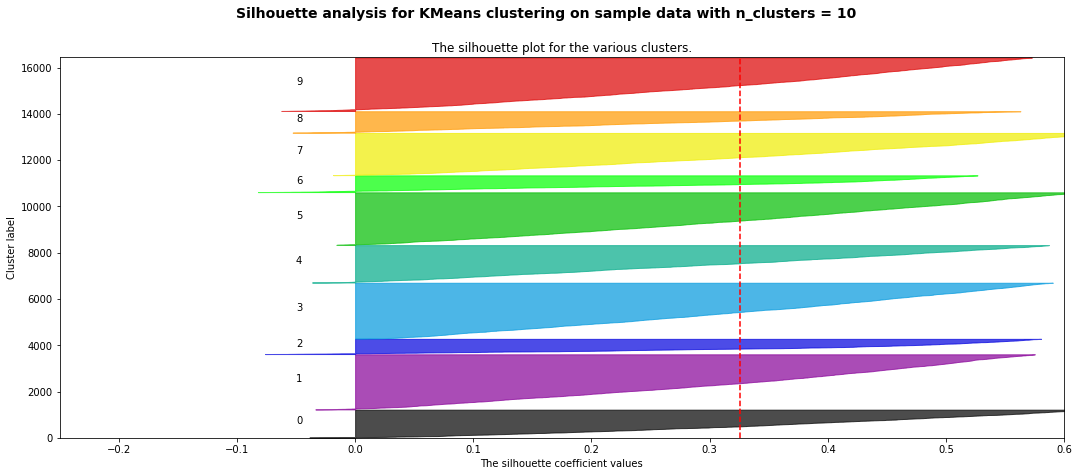

In [2]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import numpy as np

range_n_clusters=range(2,11)

clusters = []
silhouette_avgs = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax.set_xlim([-0.25, 0.6])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(points_2011) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(points_2011)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(points_2011, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    clusters.append(n_clusters)
    silhouette_avgs.append(silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(points_2011, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

__Results:__ As shown above, the silhouette score decreases with increasing K which is undesirable. However, I personally chose K = 5 as explained in the next section.

# Conduct K-Means Clustering with Five Clusters
K = 5 was chosen as analogous labeling categories to the five economic classes: Lower, Lower-Middle, Middle, Upper-Middle, and Upper. Similarly, these clusters are labelled Classes 1-5 with Class 1 having the lowest Standard of Living (SoL) and Class 5 having the highest SoL. These clusters are displayed in the scatter plots below where a Voronoi diagram (sectioned by white and gray zones) displays the cluster boundaries and the clusters themselves can "roughly" be distinguished by the following colors: Class 1 - Blue/Purple, Class 2 - Blue, Class 3 - Turquoise, Class 4 - Green, Class 5 - Yellow/Green. The color scale is based on Education Score since, in my opinion, peoples' general perception of success is based on education level.

I considered this labelling scheme not from a objective, logical perspective where there are concrete, easily definable boundaries but from a subjective, emotional perspective based on peoples' broad, spectrum-like perception of how much a person should be paid based on the same person's level of education. This accounts for the "gray" areas of understanding based on the common notions of "getting a degree as the golden ticket to success" and "obtaining a higher degree along with years of experience results in earning a six-figure salary" as the popular standards to achieve the American Dream.  In today's economy, there are people that graduated with Master's and PhD degrees, but are paid the minimum (if not, lower) livable salary. Additionally, a relatively small portion of the population don't possess Bachelor's degrees but earn higher than average salaries. 

Another way of thinking about this is what is the expected sentimental value of a zip code (Education Score) vs. what is the actual sentimental value of a zip code (Income Score).

Graphically over time, a key goal of public policymakers in all levels of government is for all zip codes to move up and to the right as shown in the scatter plots below.

### Clustering 2011 data

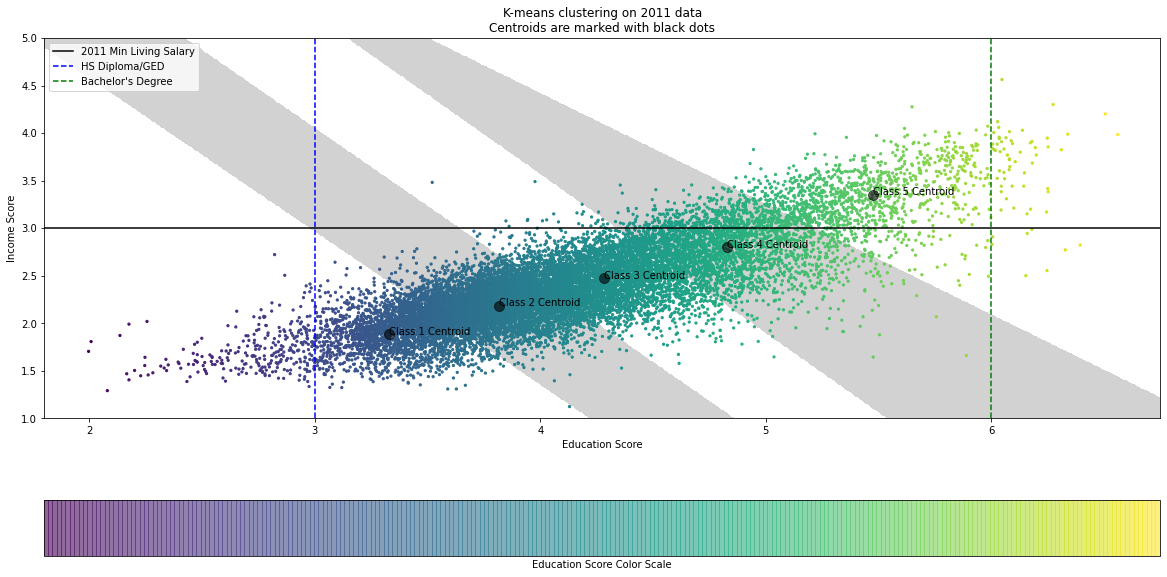

In [153]:
from scipy.spatial import Voronoi, voronoi_plot_2d 
import matplotlib
from matplotlib.colors import ListedColormap

kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(points_2011)


centers = kmeans.cluster_centers_

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .005     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = df_2011.EduScore.min() - 1, df_2011.EduScore.max() + 1
y_min, y_max = df_2011.IncomeScore.min() - 1, df_2011.IncomeScore.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

fig = plt.figure(figsize=(20,10))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=ListedColormap(["white", "dimgray", "white", "white","dimgray"]), 
           norm=matplotlib.colors.Normalize(),
           aspect='auto', origin='lower',alpha=0.3)

plt.scatter(df_2011.EduScore, df_2011.IncomeScore,c=df_2011.EduScore,s=5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.6)

plt.axhline(y=3,c='black',label='2011 Min Living Salary') # https://www.statista.com/statistics/247455/annual-us-consumer-expenditures/
plt.axvline(x=3,c='blue',ls='--',label='HS Diploma/GED')
plt.axvline(x=6,c='green',ls='--',label="Bachelor's Degree")

for n in zip([1,4,3,5,2],centroids[:, 0],centroids[:, 1]):
    plt.annotate("Class " + str(n[0]) + " Centroid",[n[1],n[2]])

plt.title('K-means clustering on 2011 data\n'
          'Centroids are marked with black dots')

plt.xlim(1.8, 6.75)
plt.ylim(1, 5)
plt.xlabel('Education Score')
plt.ylabel('Income Score')
plt.legend(loc='upper left')
plt.colorbar(orientation='horizontal',
             ticks=[num/10 for num in range(15,68,1)],
             label='Education Score Color Scale')

plt.show()

__Interpretation of Results:__ In 2011, we see that the majority of zip codes are earning less than the 2011 Minimum Living Salary (approx. $50,000 which is equivalent to a Income Score of 3, Source: Statista - US Annual Consumer Expenditures). What is also troubling to see is a small portion of zip codes in the upper right sextant of the scatter plot. Personally, I never realized growing up that the majority of Americans are being paid and educated lower than the common standards stated earlier. I just presumed that everyone was more/less achieving the common standards since the U.S. is a developed country and considered a superpower. 


### Clustering 2017 data

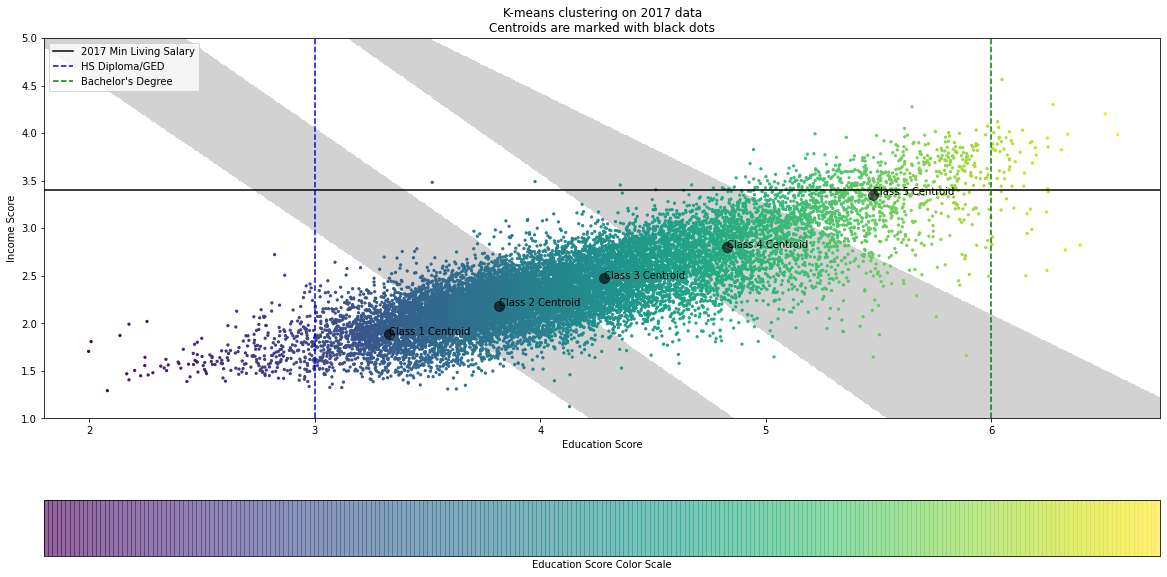

In [152]:
from scipy.spatial import Voronoi, voronoi_plot_2d 
from matplotlib.colors import ListedColormap
import matplotlib

kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(points_2017)


centers = kmeans.cluster_centers_

# Step size of the mesh
h = .005     

# Plot the decision boundary. For that, we will assign a white/gray zone to each
x_min, x_max = df_2017.EduScore.min() - 1, df_2017.EduScore.max() + 1
y_min, y_max = df_2017.IncomeScore.min() - 1, df_2017.IncomeScore.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_

plt.figure(figsize=(20,10))
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=ListedColormap(["white", "dimgray", "white", "white","dimgray"]), 
           norm=matplotlib.colors.Normalize(),
           aspect='auto', origin='lower',alpha=0.3)

plt.scatter(df_2017.EduScore, df_2017.IncomeScore,c=df_2017.EduScore,s=5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.6)

plt.axhline(y=3.4,c='black',label='2017 Min Living Salary') # https://www.statista.com/statistics/247455/annual-us-consumer-expenditures/
plt.axvline(x=3,c='blue',ls='--',label='HS Diploma/GED')
plt.axvline(x=6,c='green',ls='--',label="Bachelor's Degree")

for n in zip([1,4,3,5,2],centroids[:, 0],centroids[:, 1]):
    plt.annotate("Class " + str(n[0]) + " Centroid",[n[1],n[2]])
    
    
plt.title('K-means clustering on 2017 data\n'
          'Centroids are marked with black dots')
plt.xlim(1.8, 6.75)
plt.ylim(1, 5)
plt.xlabel('Education Score')
plt.ylabel('Income Score')
plt.legend(loc='upper left')
plt.colorbar(orientation='horizontal',
             ticks=[num/10 for num in range(15,68,1)],
             label='Education Score Color Scale')

plt.show()

# print("Class " + str(n[0]) + " Centroid: ({:.2f},{:.2f})".format(n[1],n[2]))

__Interpretation of Results:__ In 2017, we see that even more zip codes are earning less than the 2017 Minimum Living Salary which is \\$10,000 higher (approx. $60,000 which is equivalent to a Income Score of 3.4, Source: Statista - US Annual Consumer Expenditures). We also see that the clusters and centroids themselves changed only a little but although people are earning more and becoming more educated, this rate of increasing income is slower than the rate of increasing minimum livable salary. These small changes in clusters will unfortunately reinforce the common notions even though drastic change is needed.

# Conclusion

Even though the previous notebooks of this project show optimism, everyone must understand the reality of the situation the everyday American is facing now and not turn a blind eye. These findings show evidence of growing economic inequality in this country and should inform everyone how our general view of success and the American Dream will change.